In [1]:
! pip install big_O

In [2]:
import big_o

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Machine Learning Analysis

In [4]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.express as px 
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn import tree
from sklearn import ensemble
import pandas as pd
from nltk.corpus import stopwords
import string
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
dataset_path = "/content/drive/MyDrive/covid19/mongo_covid_tweets_with_sentiments_2021-09-28.csv"
df = pd.read_csv(dataset_path)
print(df.shape)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(411948, 34)


,user_name,user_location,hashtags,symbols,user_mentions,is_retweet,source,user_description,user_created,user_followers,...,cleaned_text,tweets_count,user_name_with_country,year_created,hashtags_count,day,time,hour,tweet_length,sentiment
0,hessonplumbing,ohio,"[{'text': 'statewaterheaters', 'indices': [0, ...",[],[],False,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,2010-07-23 00:18:48+00:00,17,...,statewaterheaters getitin corona keepingpeople...,1,"hessonplumbing, United States",2010,279,2020-03-19,19:53:17+00:00,19,140,positive
1,Mycox_Little,Simple Pleasures Lane,[],[],[],False,"<a href=""http://instagram.com"" rel=""nofollow"">...",sarcastic as fuck dude I'm NOT lookin 4 nothin...,2009-04-07 15:00:38+00:00,224,...,aint no humans outside corona cleveland ohio,3,"Mycox_Little, United States",2009,0,2020-03-19,19:53:46+00:00,19,83,neutral
2,Balishoo999,"Karachi, Pakistan",[],[],[],False,"<a href=""http://instagram.com"" rel=""nofollow"">...",‏🌹 اللَّهُمَّ صَلِّ عَلَى مُحَمَّدٍ وَعَلَى آل...,2015-04-30 05:00:55+00:00,179,...,salam friends looking at the grave financial s...,1,"Balishoo999, Pakistan",2015,0,2020-03-19,19:53:54+00:00,19,144,negative
3,LiezlGericke,South Africa,[],[],[],False,"<a href=""http://instagram.com"" rel=""nofollow"">...","Virgin Atlantic - Head of Middle East, Africa ...",2009-05-12 18:09:52+00:00,432,...,thanks to covid19 we are under unprecedented l...,2,"LiezlGericke, South Africa",2009,0,2020-03-19,19:54:27+00:00,19,140,positive
4,Therealyze,"Pretoria, South Africa","[{'text': 'tbt', 'indices': [0, 4]}, {'text': ...",[],[],False,"<a href=""http://instagram.com"" rel=""nofollow"">...",The official Twitter page of The Yze.🇿🇦\nSouth...,2014-12-15 17:32:46+00:00,101,...,tbt to the current anime that im rewatching wi...,9,"Therealyze, South Africa",2014,161,2020-03-19,19:55:33+00:00,19,124,neutral


##### Helper Functions

In [6]:
def tweet_to_words(raw_tweet):
    tweet = ''.join(c for c in raw_tweet if c not in string.punctuation)
    tweet = re.sub('((www\S+)|(http\S+))', 'urlsite', tweet)
    tweet = re.sub(r'\d+', 'contnum', tweet)
    tweet = re.sub(' +',' ', tweet)
    words = tweet.lower().split()                             
    stops = set(stopwords.words("english"))
                 
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))
    

In [7]:
df = df[df['country'].notna()]

#df.drop(df[df['country'] == 'United States'].sample(frac=0.80).index).drop(df[df['country'] == 'Canada'].sample(frac=0.55).index).drop(df[df['country'] == 'United Kingdom'].sample(frac=0.50).index).country.value_counts()[:3]

In [8]:
df = df.drop(df[df['country'] == 'United States'].sample(frac=0.88).index).drop(df[df['country'] == 'Canada'].sample(frac=0.80).index).drop(df[df['country'] == 'United Kingdom'].sample(frac=0.80).index).drop(df[df['country'] == 'India'].sample(frac=0.6).index)
#df = df.drop(df[df['country'] == 'United States'].sample(frac=0.3).index).drop(df[df['country'] == 'Canada'].sample(frac=0.3).index).drop(df[df['country'] == 'United Kingdom'].sample(frac=0.3).index)
df = df[df.country.isin(list(df.country.value_counts()[:5].keys()))]
df.country.value_counts()

United States     17316
Canada            13047
United Kingdom    11948
India              9413
Australia          9130
Name: country, dtype: int64

In [9]:
df['input'] = df['sentiment'] + " " + df['user_name'] + df['user_description'] + " " + df['cleaned_text']
df = df[df['input'].notna()]
df.country.value_counts()
df.drop(df[df['country'] == 'United States'].sample(frac=0.80).index).drop(df[df['country'] == 'Canada'].sample(frac=0.55).index).drop(df[df['country'] == 'United Kingdom'].sample(frac=0.50).index).country.value_counts()[:5]

India             8983
Australia         8599
Canada            5804
United Kingdom    5633
United States     3214
Name: country, dtype: int64

In [10]:
X_data = df[['input']].to_numpy().reshape(-1)
y_data = df[['country']].to_numpy().reshape(-1)

# Dataset analysis

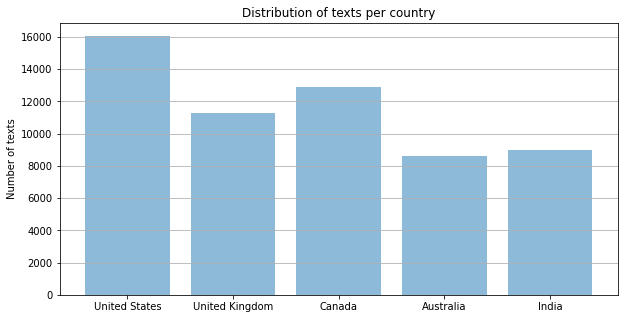

Counter({'United States': 16069, 'Canada': 12898, 'United Kingdom': 11267, 'India': 8983, 'Australia': 8599})


In [11]:
categories = df[['country']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per country')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

## Sentiment Prediction

Splitting dataset into train and test sets

In [12]:
df = df[df['cleaned_text'].notna()]
df['cleaned_text']= df['cleaned_text'].apply(lambda x: tweet_to_words(x))
train_df, test_df = train_test_split(df, test_size=0.33,random_state=0)

train_clean_tweets = train_df['cleaned_text'].tolist()
test_clean_tweets = test_df['cleaned_text'].tolist()

Get features for each set as matrix of words counts using CountVectorizer

In [13]:
count_vectorizer = CountVectorizer(analyzer = "word")
train_features = count_vectorizer.fit_transform(train_clean_tweets)
test_features = count_vectorizer.transform(test_clean_tweets)

Create a list of classifiers

In [14]:
Classifiers = [    
    #RandomForestClassifier(n_estimators=200, bootstrap=True, class_weight=None, criterion='gini',
          # max_depth=50, max_features='auto', max_leaf_nodes=None,
        #  min_samples_leaf=1, min_samples_split=2,
        # min_weight_fraction_leaf=0.0, n_jobs= -1,
       # oob_score=False, random_state=10),
    
  #AdaBoostClassifier(n_estimators=100, random_state=10),
    
  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
      
    #tree.DecisionTreeClassifier(),
    
    #ensemble.ExtraTreesClassifier(n_estimators=100,
                             #     max_features= 50,
                               #   criterion= 'entropy')#,

 #""" ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
          #learning_rate=0.001,n_estimators=50, random_state=None, verbose = 0""")
            ]
    

Fitting and evaluating classifiers

In [ ]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()

accuracies = []
models = []

for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train_df['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train_df['sentiment'])
        pred = fit.predict(dense_test)

    accuracy = accuracy_score(pred,test_df['sentiment'])
    print("Classifier Name: {}".format(classifier.__class__.__name__))
    print('>> Accuracy : {}'.format(str(accuracy)))
    accuracies.append(accuracy)
    
    print(">> Classification report for classifier {}: \n {}".format(classifier,
                                                                     classification_report(test_df['sentiment'],
                                                                     pred)))
    cm = confusion_matrix(test_df['sentiment'], pred)
    print(">> Confusion matrix: \n{}".format(cm))
    models.append(classifier.__class__.__name__)
    print("=" * 110)

Ploting the Model Performances

In [ ]:
data = pd.DataFrame({"Model":models, "Accuracy":accuracies})

fig = px.bar(
    data, 
    x="Model",
    y="Accuracy", 
    orientation='v', 
    title='Accuracies of Models', 
    width=800, 
    height=600,
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

**Get features using CountVectorizer and Ngrams**

In [ ]:
count_vectorizer = CountVectorizer(analyzer="word", 
                                   ngram_range=(1,2), 
                                   min_df=3, 
                                   max_df=.95, 
                                   stop_words='english')
train_features = count_vectorizer.fit_transform(train_clean_tweets)
test_features = count_vectorizer.transform(test_clean_tweets)

Fitting and evaluating classifiers

In [ ]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()

accuracies = []
models = []

for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train_df['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train_df['sentiment'])
        pred = fit.predict(dense_test)

    accuracy = accuracy_score(pred,test_df['sentiment'])
    print("Classifier Name: {}".format(classifier.__class__.__name__))
    print('>> Accuracy : {}'.format(str(accuracy)))
    accuracies.append(accuracy)
    
    print(">> Classification report for classifier {}: \n {}".format(classifier,
                                                                     classification_report(test_df['sentiment'],
                                                                     pred)))
    cm = confusion_matrix(test_df['sentiment'], pred)
    print(">> Confusion matrix: \n{}".format(cm))
    models.append(classifier.__class__.__name__)
    print("=" * 110)

Ploting the Model Performances after using Ngram

In [ ]:
data = pd.DataFrame({"Model":models, "Accuracy":accuracies})

fig = px.bar(
    data, 
    x="Model",
    y="Accuracy", 
    orientation='v', 
    title='Accuracies of Models using Ngrams', 
    width=800, 
    height=600,
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

## Location Prediction

Splitting dataset into train and test sets

In [ ]:
df.head()
df.shape

In [ ]:
df = df[df['input'].notna()]
df['input']= df['input'].apply(lambda x: tweet_to_words(x))
train_df, test_df = train_test_split(df, test_size=0.33,random_state=0)

train_clean_tweets = train_df['input'].tolist()
test_clean_tweets = test_df['input'].tolist()

In [ ]:
df.head()
df.shape

Get features for each set as matrix of words counts using CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer(analyzer = "word")
train_features = count_vectorizer.fit_transform(train_clean_tweets)
test_features = count_vectorizer.transform(test_clean_tweets)

Create a list of classifiers

In [ ]:
Classifiers = [    
    RandomForestClassifier(n_estimators=200, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs= -1,
            oob_score=False, random_state=10),
    
    AdaBoostClassifier(n_estimators=100, random_state=10),
    
    MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
      
    tree.DecisionTreeClassifier(),
    
    ensemble.ExtraTreesClassifier(n_estimators=100,
                                  max_features= 50,
                                  criterion= 'entropy')

    #, ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
           #   learning_rate=0.001,n_estimators=50, random_state=None, verbose = 0)
             ]
    

Fitting and evaluating classifiers

In [ ]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()

accuracies = []
models = []

for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train_df['country'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train_df['country'])
        pred = fit.predict(dense_test)

    accuracy = accuracy_score(pred,test_df['country'])
    print("Classifier Name: {}".format(classifier.__class__.__name__))
    print('>> Accuracy : {}'.format(str(accuracy)))
    accuracies.append(accuracy)
    
    print(">> Classification report for classifier {}: \n {}".format(classifier,
                                                                     classification_report(test_df['country'],
                                                                     pred)))
    cm = confusion_matrix(test_df['country'], pred)
    print(">> Confusion matrix: \n{}".format(cm))
    models.append(classifier.__class__.__name__)
    print("=" * 110)

Ploting the Model Performances

In [ ]:
data = pd.DataFrame({"Model":models, "Accuracy":accuracies})

fig = px.bar(
    data, 
    x="Model",
    y="Accuracy", 
    orientation='v', 
    title='Accuracies of Models', 
    width=800, 
    height=600,
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

**Get features using CountVectorizer and Ngrams**

In [ ]:
count_vectorizer = CountVectorizer(analyzer="word", 
                                   ngram_range=(1,2), 
                                   min_df=3, 
                                   max_df=.95, 
                                   stop_words='english')
train_features = count_vectorizer.fit_transform(train_clean_tweets)
test_features = count_vectorizer.transform(test_clean_tweets)

Fitting and evaluating classifiers

In [ ]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()

accuracies = []
models = []

for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train_df['country'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train_df['country'])
        pred = fit.predict(dense_test)

    accuracy = accuracy_score(pred,test_df['country'])
    print("Classifier Name: {}".format(classifier.__class__.__name__))
    print('>> Accuracy : {}'.format(str(accuracy)))
    accuracies.append(accuracy)
    
    print(">> Classification report for classifier {}: \n {}".format(classifier,
                                                                     classification_report(test_df['country'],
                                                                     pred)))
    cm = confusion_matrix(test_df['country'], pred)
    print(">> Confusion matrix: \n{}".format(cm))
    models.append(classifier.__class__.__name__)
    print("=" * 110)

Ploting the Model Performances after using Ngram

In [ ]:
data = pd.DataFrame({"Model":models, "Accuracy":accuracies})

fig = px.bar(
    data, 
    x="Model",
    y="Accuracy", 
    orientation='v', 
    title='Accuracies of Models using Ngrams', 
    width=800, 
    height=600,
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()